## Cykelhastigheds data 
Dette er et projekt lavet for Københavns kommunes trafikenhed, hvor vi undersøger cykelhastighederne for tællekamera, som måler cykelhastighed. 
Målet med denne undersøgelse er at finde ud af, hvad den reele cykelhastighed er, så vi dermed bedre kan optimere de grønne cykelbølger. 

For bedre at kunne forstå den data jeg ser skal jeg 
- Gå ind på maps og finde ud af, hvor langt før/efter et lydkryds sensoren er. 
- Give en flowscore på 1 - 5. Denne flowscorer skal beskrive, hvor frit flowet er en scorer på 1 vil sige at der er meget trængt på cykelstien, mens 5 betyder at der er free flow på cykelstien. 
- Også en beskrivelse af cykelstistypen: small, normal, bred 

#### Hvad jeg vil undersøge. 
Det jeg starter med at undersøge er 
En graf for hver tællested, hvor jeg laver en graf bestående af cykelintensitet og hastighed af cyklerne.  
    - 
### Hvor jeg skal starte 
- Først cleane dataen 
    - Cleane @Timestamp så jeg kan arbejde med dataen som en dato 
    - Ændre "ScalarValue" til at blive km/t, og ændre navnet til hastighed 
    - Tilføj en kollone med enhed 
    - Clean Vejnavn til KKID og Vejnavn
- Data Audit
    - Kontrol af missing data 
    - Kontrol af for store values 
    - Kontrol af for lave values 
    - Kontrol af duplicates 
- Tilføjelse af kolloner 
    - Tilføj en column baseret på, hvor tæt de er på et lyssignal. Hvis de er mindre ned lad os for nu sige 100m det vil kategoriseres som nær lyssignal ellers ikke nært lyssignal. 
    - Tilføj Flowscorer (int)
    - Tilføj type af cykelsti 

### Grafer
-Fundamentaldiagram (v vs. q): scatter + glat kurve (LOESS/GAM).
- Hastighedsfordelinger: histogram/violin/box for v opdelt efter flow-bins, narrow_lane, near_signal.
- Tidsserier: v(t) og q(t) for at spotte spids og signalbølger.
- Heatmap: time-på-dagen × ugedag → gennemsnitlig v eller q.
- Facetter: v–q for smal vs. ikke smal, nær vs. ikke nær signal.

B. Kapacitets-/struktur-indsigt:
- Breakpoint-plot: v vs. q med stykkevis lineær fit → kritisk flow.
- Kvantilkurver: v vs. q med kvantil-regression (τ = 0.5, 0.9).
- Afstand-effekt: v vs. afstand til signal (farvekod q).
- Free-flow-estimat: for free-flow subset—vis 50/85/95-percentil med CI

## Cleaning of the code 

In [296]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as st
import seaborn as sns
from matplotlib import gridspec
import openpyxl

In [297]:
# Load dataset
cykelhastighed = pd.read_csv("Vermlandsgade_cykelhastigheder.csv")
display(cykelhastighed)

,@timestamp,siteName,scalarValue,sensorName
0,"Aug 28, 2025 @ 11:04:27.993",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,4.444,KK+CO4103=001DL001 - S0202 - Average speed
1,"Aug 28, 2025 @ 11:03:39.268",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,4.722,KK+CO4103=001DL001 - S0202 - Average speed
2,"Aug 28, 2025 @ 11:03:31.321",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.611,KK+CO4103=001DL001 - S0202 - Average speed
3,"Aug 28, 2025 @ 11:03:23.415",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.889,KK+CO4103=001DL001 - S0202 - Average speed
4,"Aug 28, 2025 @ 11:01:56.461",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,5.000,KK+CO4103=001DL001 - S0202 - Average speed
...,...,...,...,...
83880,"Jul 28, 2025 @ 11:10:01.063",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.611,KK+CO4103=001DL001 - S0202 - Average speed
83881,"Jul 28, 2025 @ 11:09:44.903",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,5.000,KK+CO4103=001DL001 - S0202 - Average speed
83882,"Jul 28, 2025 @ 11:09:26.839",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,6.389,KK+CO4103=001DL001 - S0202 - Average speed
83883,"Jul 28, 2025 @ 11:08:40.749",KK-4103-CO-VIS-01 - Vermlandsgade indadgående ...,3.889,KK+CO4103=001DL001 - S0202 - Average speed


### Data cleaning 

In [298]:
# Clean Timestamp
# Remove the "@" and parse to datetime
cykelhastighed["timestamp"] = pd.to_datetime(cykelhastighed["@timestamp"].str.replace("@", ""), format="%b %d, %Y %H:%M:%S.%f")
cykelhastighed = cykelhastighed.set_index("timestamp").sort_index() # Make the timestamp the index column

# Clean of the scalar column
cykelhastighed["scalarValue"] = cykelhastighed["scalarValue"] * 3.6

# Rename the scalar colum to Hastighed
cykelhastighed = cykelhastighed.rename(columns={"scalarValue": "Hastighed"})

# Split the of the siteName column into KK-ID and Sitename
cykelhastighed[["KK-ID", "Sitename"]] = cykelhastighed["siteName"].str.extract(r"(^KK\-\d{4}\-\w{2}\-\w{3}\-\d{2})\s*-\s*([^-]+)")

# Drop columns and reorder columns
cykelhastighed = cykelhastighed.drop(columns=["@timestamp","sensorName"])
cykelhastighed = cykelhastighed[["KK-ID", "Sitename", "Hastighed"]]

In [306]:
display(cykelhastighed)

,KK-ID,Sitename,Hastighed
timestamp,,,
2025-07-28 11:08:26.339,KK-4103-CO-VIS-01,Vermlandsgade indadgående,23.0004
2025-07-28 11:08:40.749,KK-4103-CO-VIS-01,Vermlandsgade indadgående,14.0004
2025-07-28 11:09:26.839,KK-4103-CO-VIS-01,Vermlandsgade indadgående,23.0004
2025-07-28 11:09:44.903,KK-4103-CO-VIS-01,Vermlandsgade indadgående,18.0000
2025-07-28 11:10:01.063,KK-4103-CO-VIS-01,Vermlandsgade indadgående,12.9996
...,...,...,...
2025-08-28 11:01:56.461,KK-4103-CO-VIS-01,Vermlandsgade indadgående,18.0000
2025-08-28 11:03:23.415,KK-4103-CO-VIS-01,Vermlandsgade indadgående,14.0004
2025-08-28 11:03:31.321,KK-4103-CO-VIS-01,Vermlandsgade indadgående,12.9996


### Initial graph plots

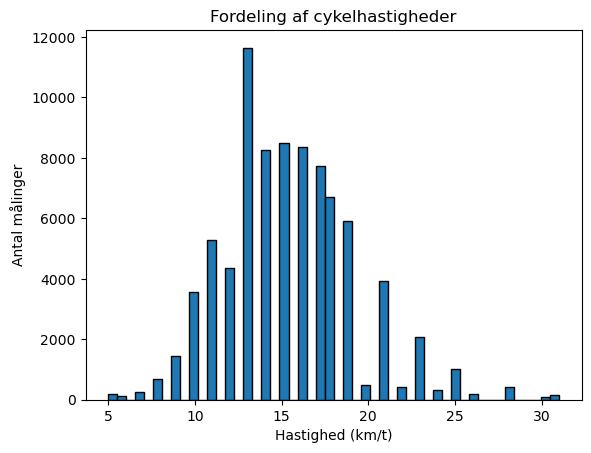

count    82199.000000
mean        15.438179
std          3.774814
min          5.000400
25%         12.999600
50%         15.001200
75%         18.000000
max         30.999600
Name: Hastighed, dtype: float64

In [309]:
# Basic statistics
summary_stats = cykelhastighed["Hastighed"].describe()

# Plot histogram to visualize distribution
plt.hist(cykelhastighed["Hastighed"], bins=50, edgecolor="black")
plt.xlabel("Hastighed (km/t)")
plt.ylabel("Antal målinger")
plt.title("Fordeling af cykelhastigheder")
plt.show()

summary_stats

### Drop of speeds below 5 and above 31 
Baseret på ovenstående plot, har jeg valgt at droppe hastigheder under 5 km/t og højere end 31 kmt/t, da vi ellers kommer ud i nogle outliers, som vi i dette tilfælde ikke er intereseret I, vi prøver at tilpasse, vores, data til den gennemsnitlige cykelist. 

In [302]:
cykelhastighed = cykelhastighed[(cykelhastighed["Hastighed"] >= 5) & (cykelhastighed["Hastighed"] <= 31)]

display(cykelhastighed)

,KK-ID,Sitename,Hastighed
timestamp,,,
2025-07-28 11:08:26.339,KK-4103-CO-VIS-01,Vermlandsgade indadgående,23.0004
2025-07-28 11:08:40.749,KK-4103-CO-VIS-01,Vermlandsgade indadgående,14.0004
2025-07-28 11:09:26.839,KK-4103-CO-VIS-01,Vermlandsgade indadgående,23.0004
2025-07-28 11:09:44.903,KK-4103-CO-VIS-01,Vermlandsgade indadgående,18.0000
2025-07-28 11:10:01.063,KK-4103-CO-VIS-01,Vermlandsgade indadgående,12.9996
...,...,...,...
2025-08-28 11:01:56.461,KK-4103-CO-VIS-01,Vermlandsgade indadgående,18.0000
2025-08-28 11:03:23.415,KK-4103-CO-VIS-01,Vermlandsgade indadgående,14.0004
2025-08-28 11:03:31.321,KK-4103-CO-VIS-01,Vermlandsgade indadgående,12.9996


## Generate plots 

### Fordeling af cykelhastigheder

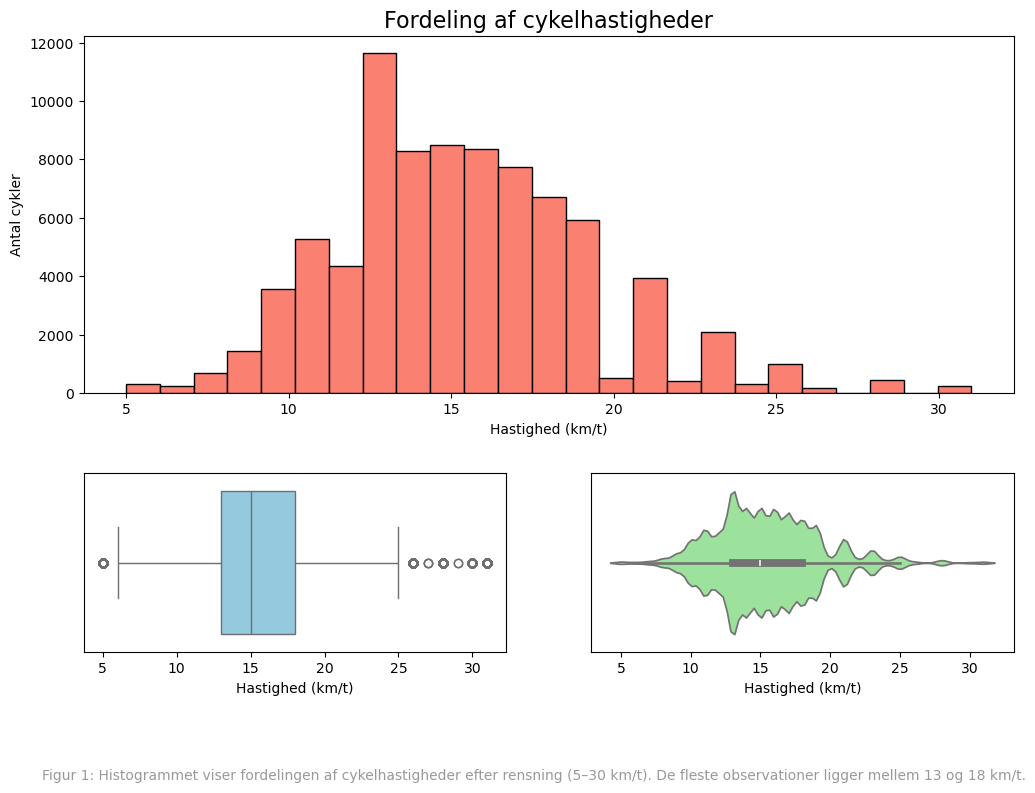

In [328]:
# The data I need for the plots
data = cykelhastighed["Hastighed"]

# Use GridSpec from matplotlib.gridspec
fig = plt.figure(figsize=(12, 8))
grid = gridspec.GridSpec(2, 2, height_ratios=[4, 2], hspace=0.3)

# Header settings
fontd = {'fontsize': 16, 'color': 'black'}

# Histogram (top, spanning both columns)
ax_hist = fig.add_subplot(grid[0, :])
ax_hist.hist(data, bins=25, edgecolor="black",  color="salmon")
ax_hist.set_xlabel("Hastighed (km/t)")
ax_hist.set_ylabel("Antal cykler")
ax_hist.set_title("Fordeling af cykelhastigheder", fontdict=fontd)

# Boxplot (bottom left)
ax_box = fig.add_subplot(grid[1, 0])
sns.boxplot(x=data, ax=ax_box, color="skyblue")
ax_box.set_xlabel("Hastighed (km/t)")
ax_box.set_yticks([])

# Violin plot (bottom right)
ax_violin = fig.add_subplot(grid[1, 1])
sns.violinplot(x=data, ax=ax_violin, inner="box", color="lightgreen")
ax_violin.set_xlabel("Hastighed (km/t)")
ax_violin.set_yticks([])
# Caption below figure
fig.text(
    0.5, -0.05,   # x=0.5 centers it, y=-0.05 places below the plot
    "Figur 1: Histogrammet viser fordelingen af cykelhastigheder "
    "efter rensning (5–30 km/t). De fleste observationer ligger "
    "mellem 13 og 18 km/t.",
    ha="center", fontsize=10, color="grey", alpha=0.8
)

plt.show()


### Theory of the LOWESS 

### 

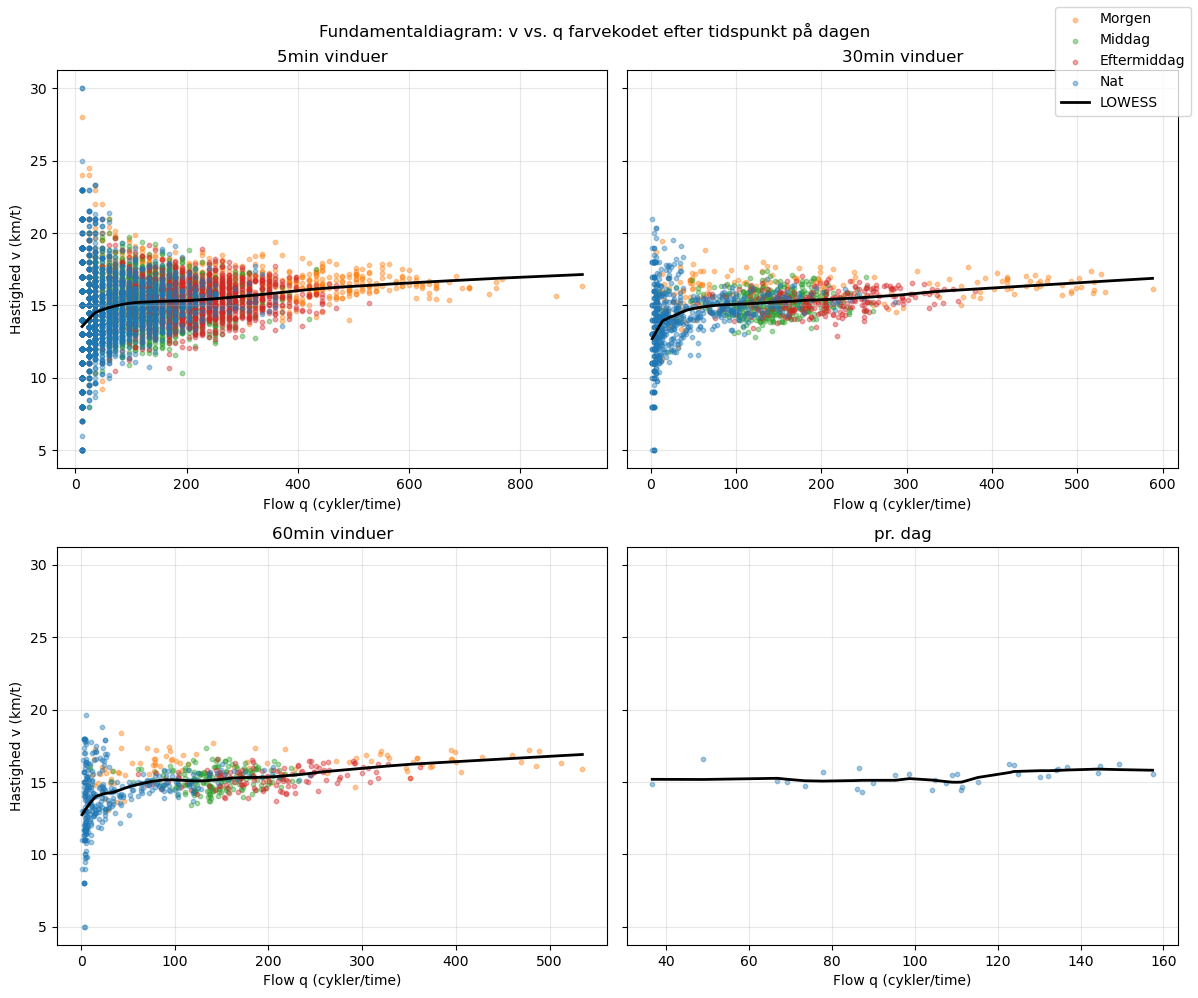


=== Hovedtabel til signalplanlægning (30 min, 1 time, 1 dag) ===
               Antal vinduer  Gns. hastighed (km/t)  Median hastighed (km/t)  \
Tidsopløsning                                                                  
30 min                  1480                  14.79                    15.02   
1 time                   743                  14.81                    15.00   
1 dag                     32                  15.38                    15.46   

               Std. hastighed (km/t)  Min hastighed (km/t)  \
Tidsopløsning                                                
30 min                          1.82                  5.00   
1 time                          1.65                  5.00   
1 dag                           0.60                 14.32   

               Maks hastighed (km/t)  Gns. flow q (cykler/time)  \
Tidsopløsning                                                     
30 min                         21.00                     111.08   
1 time               

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Antag df er et DataFrame med datetime-indeks og en kolonne "Hastighed"
df = cykelhastighed.rename(columns={"Hasighed": "Hastighed"})

# ---------- helpers ----------
def prepare_data(df, freq):
    """Resample -> v (mean speed), n (count), q (flow bikes/hour) + hour for coloring."""
    agg = df["Hastighed"].resample(freq).agg(["mean", "size"]).dropna()
    agg = agg.rename(columns={"mean": "v", "size": "n"})
    minutes = pd.to_timedelta(freq).total_seconds() / 60.0
    agg["q"] = agg["n"] * (60.0 / minutes)          # cykler/time
    # hour exists for sub-daily freqs; for daily we put mid-day (12) only for labeling logic
    agg["hour"] = getattr(agg.index, "hour", pd.Index(np.full(len(agg), 12, dtype=int)))
    return agg

def time_of_day_label(hour):
    if 6 <= hour < 9:
        return "Morgen"
    elif 9 <= hour < 15:
        return "Middag"
    elif 15 <= hour < 19:
        return "Eftermiddag"
    else:
        return "Nat"

colors = {"Morgen": "tab:orange", "Middag": "tab:green", "Eftermiddag": "tab:red", "Nat": "tab:blue"}

# ---------- plotting (unchanged behavior) ----------
freqs = [("5min", 0.3, "5min vinduer"),
         ("30min", 0.3, "30min vinduer"),
         ("60min", 0.3, "60min vinduer"),
         ("1D",   0.4, "pr. dag")]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for ax, (freq, frac, title) in zip(axes.ravel(), freqs):
    agg = prepare_data(df, freq)

    labels = agg["hour"].apply(time_of_day_label)
    for label, color in colors.items():
        mask = labels == label
        ax.scatter(agg.loc[mask, "q"], agg.loc[mask, "v"], s=10, alpha=0.4, label=label, color=color)

    smoothed = lowess(agg["v"], agg["q"], frac=frac, return_sorted=True)
    ax.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2, color="black", label="LOWESS")

    ax.set_title(title)
    ax.set_xlabel("Flow q (cykler/time)")
    ax.grid(True, alpha=0.3)

axes[0,0].set_ylabel("Hastighed v (km/t)")
axes[1,0].set_ylabel("Hastighed v (km/t)")

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.suptitle("Fundamentaldiagram: v vs. q farvekodet efter tidspunkt på dagen")
plt.tight_layout()
plt.show()

# ---------- SUMMARY TABLES (overall, as before) ----------
summary_freqs = {"30min": "30 min", "60min": "1 time", "1D": "1 dag"}

rows = []
for freq, label in summary_freqs.items():
    agg = prepare_data(df, freq)
    rows.append({
        "Tidsopløsning": label,
        "Antal vinduer": len(agg),
        "Gns. hastighed (km/t)": agg["v"].mean(),
        "Median hastighed (km/t)": agg["v"].median(),
        "Std. hastighed (km/t)": agg["v"].std(),
        "Min hastighed (km/t)": agg["v"].min(),
        "Maks hastighed (km/t)": agg["v"].max(),
        "Gns. flow q (cykler/time)": agg["q"].mean(),
        "Maks flow q (cykler/time)": agg["q"].max(),
    })

summary_df = pd.DataFrame(rows).set_index("Tidsopløsning").round(2)
print("\n=== Hovedtabel til signalplanlægning (30 min, 1 time, 1 dag) ===")
print(summary_df)

# ---------- NEW: MONTHLY SUMMARY ----------
# One row per (month x tidsopløsning)
month_rows = []
for freq, label in summary_freqs.items():
    agg = prepare_data(df, freq)

    # month number and month name
    month_num = agg.index.month
    month_name = agg.index.month_name(locale="en_US")  # change locale if desired

    agg = agg.assign(MonthNo=month_num, MonthName=month_name)

    for m, g in agg.groupby("MonthNo"):  # stable numeric order
        month_rows.append({
            "Måned": pd.to_datetime(str(m), format="%m").strftime("%B"),  # localized name
            "MånedNr": m,
            "Tidsopløsning": label,
            "Vinduer": len(g),
            "Gns. hastighed (km/t)": g["v"].mean(),
            "Median hastighed (km/t)": g["v"].median(),
            "Std. hastighed (km/t)": g["v"].std(),
            "Min hastighed (km/t)": g["v"].min(),
            "Maks hastighed (km/t)": g["v"].max(),
            "Gns. flow q (cykler/time)": g["q"].mean(),
            "Maks flow q (cykler/time)": g["q"].max(),
        })

summary_monthly = (
    pd.DataFrame(month_rows)
      .sort_values(["MånedNr", "Tidsopløsning"])
      .drop(columns=["MånedNr"])
      .set_index(["Måned", "Tidsopløsning"])
      .round(2)
)

print("\n=== Månedlig oversigt (30 min, 1 time, 1 dag) ===")
print(summary_monthly)

# ---------- OPTIONAL: MONTHLY x TIME-OF-DAY SUMMARY ----------
tod_month_rows = []
for freq, label in summary_freqs.items():
    agg = prepare_data(df, freq)
    agg["ToD"] = agg["hour"].apply(time_of_day_label)
    agg = agg.assign(Måned=agg.index.month)

    for (m, tod), g in agg.groupby(["Måned", "ToD"]):
        tod_month_rows.append({
            "Måned": pd.to_datetime(str(m), format="%m").strftime("%B"),
            "Tidsopløsning": label,
            "Tid på dagen": tod,
            "Vinduer": len(g),
            "Gns. v (km/t)": g["v"].mean(),
            "Median v (km/t)": g["v"].median(),
            "Std. v (km/t)": g["v"].std(),
            "Gns. q (cykler/time)": g["q"].mean()
        })

tod_order = pd.CategoricalDtype(["Morgen", "Middag", "Eftermiddag", "Nat"], ordered=True)
tod_monthly = pd.DataFrame(tod_month_rows)
tod_monthly["Tid på dagen"] = tod_monthly["Tid på dagen"].astype(tod_order)
tod_monthly = tod_monthly.sort_values(["Måned", "Tidsopløsning", "Tid på dagen"]).round(2)

print("\n=== Måned x tidsdøgn (valgfri, til detaljer) ===")
print(tod_monthly)

# If you want files:
summary_df.to_excel("cykeldiagram_summary_main.xlsx")
summary_monthly.to_excel("cykeldiagram_summary_monthly.xlsx")
tod_monthly.to_excel("cykeldiagram_summary_monthly_tod.xlsx")
